<a href="https://colab.research.google.com/github/Alex-U02/Zajecia/blob/main/reg_cat_zadanie_AMES_HOUSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [ ]:
house = pd.read_csv("data/house_sales.csv", sep="\t")
print(house.head(3))

  DocumentDate  SalePrice  PropertyID  ... ImpsVal ZipCode  NewConstruction
1   2014-09-16     280000     1000102  ...  229000   98002            False
2   2006-06-16    1000000     1200013  ...  590000   98166             True
3   2007-01-29     745000     1200019  ...  275000   98166            False

[3 rows x 22 columns]


In [ ]:
predictors_num = ['SqFtTotLiving', 'BldgGrade']
categorical = ['PropertyType']
outcome = 'AdjSalePrice'

columns_needed = predictors_num + categorical + [outcome]
house_clean = house[columns_needed].dropna().reset_index(drop=True)

print(f"Dane: {len(house_clean)} wierszy")

Dane: 22687 wierszy


In [ ]:
# ========================================
# KROK 1: STANDARYZUJ ZMIENNE NUMERYCZNE
# ========================================
scaler = StandardScaler()
X_num = house_clean[predictors_num].copy()
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num_scaled, columns=predictors_num, index=house_clean.index)

print("Zmienne numeryczne (standaryzowane):")
print(X_num_scaled.describe().round(3))

Zmienne numeryczne (standaryzowane):
       SqFtTotLiving  BldgGrade
count      22687.000  22687.000
mean          -0.000      0.000
std            1.000      1.000
min           -1.872     -3.965
25%           -0.723     -0.577
50%           -0.186     -0.577
75%            0.503      0.270
max            9.478      4.506


In [ ]:
# ========================================
# KROK 2: DUMMY VARIABLES
# ========================================
X_cat = pd.get_dummies(house_clean['PropertyType'], drop_first=True)

In [ ]:
# ========================================
# KROK 3: POŁĄCZ
# ========================================
X = pd.concat([X_num_scaled, X_cat], axis=1)
y = house_clean[outcome]

In [ ]:
# ========================================
# KROK 4: TRENUJ MODEL
# ========================================
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

In [ ]:
# ========================================
# KROK 5: WYNIKI
# ========================================
print("="*60)
print("MODEL REGRESJI")
print("="*60)
print(f"\nRMSE: ${rmse:,.0f}")
print(f"R²: {r2:.4f}")
print()

print("WSPÓŁCZYNNIKI (zmienne standaryzowane):")
print(f"b₀ (Intercept): ${model.intercept_:,.0f}")
print("  → Bazowa cena (średnie wartości zmiennych)")
print()

for i, feature in enumerate(predictors_num):
    std_dev = scaler.scale_[i]
    print(f"b{i+1} ({feature}): ${model.coef_[i]:,.0f}")
    print(f"  → Wzrost o 1 odch.std ({std_dev:,.0f} {feature}) = +${model.coef_[i]:,.0f}")

print()

for i, feature in enumerate(X_cat.columns):
    idx = len(predictors_num) + i
    print(f"b{len(predictors_num)+i+1} ({feature}): ${model.coef_[idx]:,.0f}")
    print(f"  → {feature} vs Multiplex: ${model.coef_[idx]:,.0f}")

print()

MODEL REGRESJI

RMSE: $263,718
R²: 0.5318

WSPÓŁCZYNNIKI (zmienne standaryzowane):
b₀ (Intercept): $603,184
  → Bazowa cena (średnie wartości zmiennych)

b1 (SqFtTotLiving): $161,822
  → Wzrost o 1 odch.std (914 SqFtTotLiving) = +$161,822
b2 (BldgGrade): $136,058
  → Wzrost o 1 odch.std (1 BldgGrade) = +$136,058

b3 (Single Family): $-36,612
  → Single Family vs Multiplex: $-36,612
b4 (Townhouse): $-59,886
  → Townhouse vs Multiplex: $-59,886



In [ ]:
# ========================================
# KROK 6: INTERPRETACJA
# ========================================
print("="*60)
print("INTERPRETACJA (w jednostkach oryginalnych)")
print("="*60)
print()

coef_sqft = model.coef_[0] / scaler.scale_[0]
coef_grade = model.coef_[1] / scaler.scale_[1]

print(f"Każdy sqft więcej → +${coef_sqft:,.2f}")
print(f"Każdy grade wyżej → +${coef_grade:,.0f}")
print()


INTERPRETACJA (w jednostkach oryginalnych)

Każdy sqft więcej → +$177.10
Każdy grade wyżej → +$115,261



In [ ]:
# ========================================
# KROK 7: PREDYKCJA
# ========================================
print("="*60)
print("PREDYKCJA (średnie wartości)")
print("="*60)
print()

# Dom Multiplex - średnie cechy (standaryzacja = 0)
new_house_1 = pd.DataFrame({
    'SqFtTotLiving': [0],  # 0 = średnia (standaryzowana)
    'BldgGrade': [0]
})
for col in X_cat.columns:
    new_house_1[col] = 0

price_1 = model.predict(new_house_1)[0]
print(f"Multiplex (średnie cechy): ${price_1:,.0f}")

# Inne PropertyType
for cat in X_cat.columns:
    new_house = pd.DataFrame({
        'SqFtTotLiving': [0],
        'BldgGrade': [0]
    })
    for col in X_cat.columns:
        new_house[col] = 0
    new_house[cat] = 1

    price_cat = model.predict(new_house)[0]
    diff = price_cat - price_1
    print(f"{cat} (średnie cechy): ${price_cat:,.0f} (różnica: ${diff:,.0f})")

PREDYKCJA (średnie wartości)

Multiplex (średnie cechy): $603,184
Single Family (średnie cechy): $566,573 (różnica: $-36,612)
Townhouse (średnie cechy): $543,298 (różnica: $-59,886)




---


**Zadanie** - budowanie modelu regresji wielokrotnej dla **AMES Housing Price
Prediction**

---



Zmienne numeryczne:
       MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
count    1460.000     1460.000  1460.000     1460.000     1460.000   1460.000   
mean       -0.000       -0.000     0.000        0.000       -0.000      0.000   
std         1.000        1.000     1.000        1.000        1.000      1.000   
min        -0.873       -2.228    -0.924       -3.688       -4.113     -3.288   
25%        -0.873       -0.456    -0.297       -0.795       -0.517     -0.572   
50%        -0.163        0.000    -0.104       -0.072       -0.517      0.057   
75%         0.310        0.407     0.109        0.651        0.382      0.952   
max         3.148       11.035    20.518        2.821        3.079      1.283   

       YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
count      1460.000    1460.000    1460.000    1460.000  ...    1460.000   
mean          0.000      -0.000      -0.000       0.000  ...      -0.000   
std           1.000   

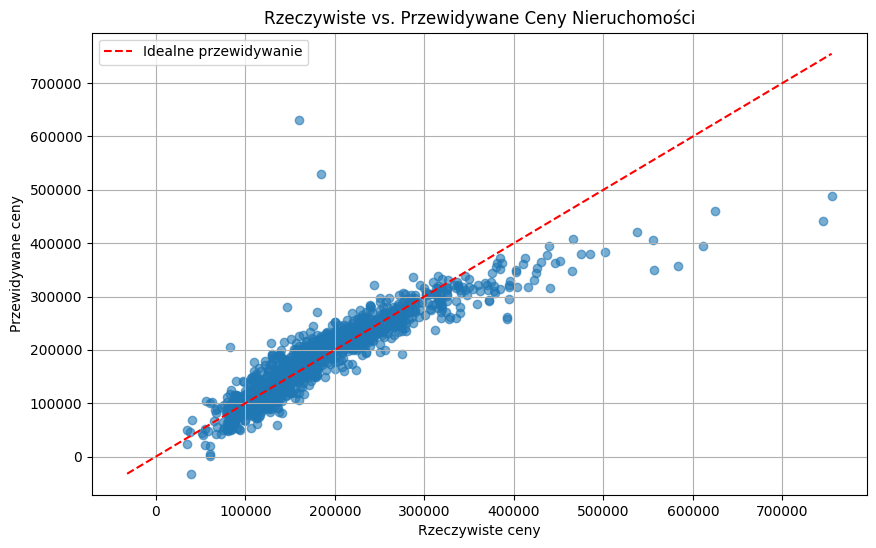

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# KROK 1: STANDARYZUJ ZMIENNE NUMERYCZNE

feature_cols = [col for col in numeric_cols if col not in ['Id', target_variable]]

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df_housing[feature_cols])
X_num_scaled = pd.DataFrame(X_num_scaled, columns=feature_cols, index=df_housing.index)

print("Zmienne numeryczne:")
print(X_num_scaled.describe().round(3))

# KROK 2: POŁĄCZ ZMIENNE

X = X_num_scaled
y = df_housing[target_variable]

# KROK 3: TRENUJ MODEL

model = LinearRegression()
model.fit(X, y)

# KROK 5: WYNIKI

y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("MODEL REGRESJI (AMES Housing Price Prediction)")
print(f"\nRMSE: ${rmse:,.0f}")
print(f"R²: {r2:.4f}")
print()

print("WSPÓŁCZYNNIKI:")
print(f"b₀: ${model.intercept_:,.0f}")
print("  → Bazowa cena")
print()

for i, feature in enumerate(feature_cols):
    std_dev = scaler.scale_[i]
    print(f"b{i+1} ({feature}): ${model.coef_[i]:,.0f}")
    print(f"  → Wzrost o 1 odch.std ({std_dev:,.0f} {feature}) = +${model.coef_[i]:,.0f}")

print()


# KROK 6: INTERPRETACJA

print("INTERPRETACJA")
print()

for i, feature in enumerate(feature_cols):

    if scaler.scale_[i] != 0:
        coef_original_unit = model.coef_[i] / scaler.scale_[i]
        print(f"Każda jednostka więcej {feature} → +${coef_original_unit:,.2f}")
    else:
        print(f"Feature {feature} ma zerowe odchylenie standardowe. Interpretacja w jednostkach oryginalnych niemożliwa.")
print()


# KROK 7: PREDYKCJA

print("PREDYKCJA")
print()

new_house_avg = pd.DataFrame({col: [0] for col in feature_cols})

price_avg = model.predict(new_house_avg)[0]
print(f"Przewidywana cena dla domu o średnich cechach: ${price_avg:,.0f}")

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.6)

plt.xlabel('Rzeczywiste ceny')
plt.ylabel('Przewidywane ceny')
plt.title('Rzeczywiste vs. Przewidywane Ceny Nieruchomości')

min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Idealne przewidywanie')

plt.legend()
plt.grid(True)
plt.show()